# Common Ground
## An in-depth analysis of the connectivity of Wikipedia

Summary of the Notebook:
- Libraries
- Data Loading
- Exploration
    - Building graph of categories
    - Plot the graph of wikipedia
    - Condensed graph
- Application 1: Finding the shortest path between two nodes
    - Defining functions
    - main
    - Path vizualization
    - Checking path length lower than 7
- Application 2: Building category relationship graph
    - Defining functions
    - main
- Application 3: suggest gateway articles between two categories
    - Defining functions
    - main

### Libraries

In [52]:
import numpy as np
import pandas as pd
import time
import random as rnd
import networkx as nx
import matplotlib.pyplot as plt
import operator
try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either "
                          "PyGraphviz or pydot")
from collections import defaultdict

### Data Loading

In [53]:
#### this function is used to decode the characters in the dataframe
import urllib
# input: a dataframe with encoded characters
# output: the same dataframe, with decoded characters
def make_df_readable(dataframe):
    for idx, rows in dataframe.iterrows():
        text = dataframe.loc[idx,'title']
        decoded_text = urllib.parse.unquote(text)
        decoded_text = decoded_text.replace("_", " ")
        dataframe.at[idx, 'title'] = decoded_text
    return dataframe

In [54]:
dataframe = pd.read_csv('dataframe_final.tsv', sep='\t', encoding='utf-8', engine='python') #dataframe of main component
dataframe = make_df_readable(dataframe)
adjacency = np.load('adjacency_final.npy') #directed adjacency matrix of main component

#adjaceny[i,j] = 1 means link i->j exists (directed)

n_nodes = len(adjacency)

# Exploration

## Building graph of the category

### Building the tree structure

Calcuate the size of each category (how many pages is in), and build the graph of categories. By finding the parents and child of each ones.

In [55]:
class position:
    x = 0
    y = 0
    
class cat: #Definition of the class category
    id = 0
    def __init__(self, name, place, parent = None, child = None):
        self.name = name
        self.place = place
        self.parent = parent
        self.child = child or []
        self.n_child = 0 #number of child
        self.node_id = []
        self.n_node = 0 #number of nodes(site)
        self.position = None
    def add_child(self, child):
        self.child.append(cat(child.name,child.place, parent = self, child=child.child)) 
        self.n_child += 1
    def add_node(self,node_idx):
        self.node_id.append(node_idx)
        self.n_node += 1
    def is_root(self):
        if self.parent is None:
            return True
        else:
            return False
    def is_leaf(self):
        if self.n_child==0:
            return True
        else:
            return False

In [56]:
#create the data struct representing the tree
root = cat("subject",0,None)#create the root
cat_list = []
cat_list.append(root)
already_exist_cat_name = [[],[],[],[],[],[],[]]
already_exist_cat_name[0].append(root.name)
parent = root
for node_id in range(len(dataframe)):
    text = dataframe.loc[node_id, 'Label1']
    for n_cat in range(len(text.split("."))):
        category = text.split(".")[n_cat] #subcategories are separate with .
        #print("n_cat:",n_cat,"cat:",category)
        if category != "None":
            cat_new = cat(category, n_cat, parent)
            #print("parent",cat_new.parent.name)
            if cat_new.name not in already_exist_cat_name[n_cat]: #for new category
                already_exist_cat_name[n_cat].append(cat_new.name)
                cat_list.append(cat_new)
                cat_new.add_node(node_id) #add node
                cat_new.parent.add_child(cat_new) #add child to the parent
                #print("id:", node_id,"parent:",cat_new.parent.name,"\t name_cat:",cat_new.parent.child[-1].name)
                parent = cat_new
            else:
                #find the existing category
                for idx in range(len(cat_list)):
                    if category == cat_list[idx].name:
                        cat_list[idx].add_node(node_id)
                        parent = cat_list[idx]

In [57]:
#the part above only connected the child with the parent, but a child with name x where not the parent of same name x
#this part assemble the levels of the tree to have only one tree accessible from root
for h in range(len(cat_list)):
    for i in range(len(cat_list[h].child)):
        for idg in range(len(cat_list)):
            if cat_list[h].child[i].name == cat_list[idg].name:
                if cat_list[h].child[i].place== cat_list[idg].place:
                    idx=idg
        cat_list[h].child[i] = cat_list[idx]
        cat_list[idx].parent = cat_list[h]
        for j in range(len(cat_list[h].child[i].child)):
            for idg in range(len(cat_list)):
                if cat_list[h].child[i].child[j].name == cat_list[idg].name:
                    if cat_list[h].child[i].child[j].place== cat_list[idg].place:
                        idxx=idg
            cat_list[h].child[i].child[j] = cat_list[idxx]
            cat_list[idxx].parent = cat_list[h].child[i]
            for k in range(len(cat_list[h].child[i].child[j].child)):
                for idg in range(len(cat_list)):
                    if cat_list[h].child[i].child[j].child[k].name == cat_list[idg].name:
                        if cat_list[h].child[i].child[j].child[k].place== cat_list[idg].place:
                            idxxx=idg
                cat_list[h].child[i].child[j].child[k] = cat_list[idxxx]
                cat_list[idxxx].parent = cat_list[h].child[i].child[j]

Resuting tree:

In [58]:
count = 0
count_node = 0
count_child = 0
compare = []
compare.append(root.name)
print(root.name,"n_child:", root.n_child, "\t size:", root.n_node)
count+=1
count_child += root.n_child
count_node += root.n_node
for i in range(len(root.child)):
    count+=1
    count_child += root.child[i].n_child
    count_node += root.child[i].n_node
    print("\t",root.child[i].name,"n_child:", root.child[i].n_child, "\t size:", root.child[i].n_node)
    compare.append(root.child[i].name)
    for j in range(len(root.child[i].child)):
        count+=1
        count_child += root.child[i].child[j].n_child
        count_node += root.child[i].child[j].n_node
        print("\t","\t", root.child[i].child[j].name,"n_child:",root.child[i].child[j].n_child,"\t size:", root.child[i].child[j].n_node)
        compare.append(root.child[i].child[j].name)
        for k in range(len(root.child[i].child[j].child)):
            count+=1
            count_child += root.child[i].child[j].child[k].n_child
            count_node += root.child[i].child[j].child[k].n_node
            print("\t","\t \t", root.child[i].child[j].child[k].name,"n_child:",root.child[i].child[j].child[k].n_child,"\t size:", root.child[i].child[j].child[k].n_node)
            compare.append(root.child[i].child[j].child[k].name)

print("\n nb cat_list:",len(cat_list))    
nb_category = len(cat_list)
print("There is",count,"categories in total")
print("count_child",count_child)
print("count_node",count_node)
print("exemple:",root.child[0].child[0].child[0].name)
compare_cat_list=[]
for i in range(len(cat_list)):
    compare_cat_list.append(cat_list[i].name)
    
print("The difference of all node and the tree is: ",list(set(compare_cat_list) - set(compare)))

subject n_child: 15 	 size: 4588
	 History n_child: 10 	 size: 479
	 	 British_History n_child: 4 	 size: 122
	 	 	 British_History_1500_and_before_including_Roman_Britain n_child: 0 	 size: 61
	 	 	 British_History_15001750 n_child: 0 	 size: 21
	 	 	 British_History_17501900 n_child: 0 	 size: 17
	 	 	 British_History_Post_1900 n_child: 0 	 size: 14
	 	 General_history n_child: 0 	 size: 76
	 	 Military_History_and_War n_child: 0 	 size: 66
	 	 Recent_History n_child: 0 	 size: 42
	 	 Ancient_History_Classical_History_and_Mythology n_child: 0 	 size: 82
	 	 Pre_1900_Military n_child: 0 	 size: 26
	 	 Archaeology n_child: 0 	 size: 11
	 	 Historians_chroniclers_and_history_books n_child: 0 	 size: 8
	 	 World_War_II n_child: 0 	 size: 24
	 	 North_American_History n_child: 0 	 size: 22
	 Countries n_child: 0 	 size: 97
	 People n_child: 19 	 size: 611
	 	 Artists n_child: 0 	 size: 37
	 	 Sports_and_games_people n_child: 0 	 size: 45
	 	 Historical_figures n_child: 0 	 size: 85
	 	 Ge

### Plot the graph of category

In [59]:
#create a hash table to access a data by name and an adjacency of the graph
#assign an id to each

#this adjacency represent the graph of the category
adj_cat = np.zeros((nb_category, nb_category)) 
node_tree_map_name = {}
node_tree_map_id = {}
count = 0
root 
node_tree_map_name[root.name] = root 
node_tree_map_id[count] = root 
for i in range(len(root.child)):
    count+=1
    node_tree_map_name[root.child[i].name] = root.child[i]
    node_tree_map_id[count] = root.child[i]
    root.child[i].id = count
    #adj_cat[root.child[i].parent.id][root.child[i].id]=root.child[i].n_node
    for j in range(len(root.child[i].child)):
        count+=1
        node_tree_map_name[root.child[i].child[j].name] = root.child[i].child[j]
        node_tree_map_id[count] = root.child[i].child[j]
        root.child[i].child[j].id = count
        #adj_cat[root.child[i].child[j].parent.id][root.child[i].child[j].id]=root.child[i].child[j].n_node
        for k in range(len(root.child[i].child[j].child)):
            count+=1
            node_tree_map_name[root.child[i].child[j].child[k].name] = root.child[i].child[j].child[k]
            node_tree_map_id[count] = root.child[i].child[j].child[k]
            root.child[i].child[j].child[k].id = count
            #adj_cat[root.child[i].child[j].child[k].parent.id][root.child[i].child[j].child[k].id]=root.child[i].child[j].child[k].n_node
#create list with all the node accessible by name or id.            
print("Exemple name: ",node_tree_map_name['subject'].id)
print("Exemple id:", node_tree_map_id[0].name)
mapping_name = {}
mapping_name_size= {}
mapping_name_place= {}
mapping_name[0]=node_tree_map_id[0].name
mapping_name_size[0]=node_tree_map_id[0].n_node
mapping_name_place[0]=node_tree_map_id[0].place
for i in range(len(node_tree_map_id)):
    if node_tree_map_id[i].parent is not None:
        mapping_name[i]=node_tree_map_id[i].name
        mapping_name_size[node_tree_map_id[i].name]=node_tree_map_id[i].n_node
        mapping_name_place[node_tree_map_id[i].name]=node_tree_map_id[i].place
        adj_cat[node_tree_map_id[i].parent.id,node_tree_map_id[i].id]=node_tree_map_id[i].n_node

Exemple name:  0
Exemple id: subject


In [60]:
G_cat = nx.from_numpy_matrix(adj_cat);
G_cat = nx.relabel_nodes(G_cat,mapping_name);
nx.set_node_attributes(G_cat, mapping_name_size,name='size')
nx.set_node_attributes(G_cat, mapping_name_place,name='place')
nx.write_gexf(G_cat, 'wikipedia_category.gexf')

## Plot the graph of wikipedia

In [61]:
def find_cat(node):
    #This function return the most subcategory of a node(site)
    category=''
    level = -1
    for i in range(len(node_tree_map_id)):
        list_node=node_tree_map_id[i].node_id
        if node in list_node:
            idx = list_node.index(node)
            if node_tree_map_id[i].place > level:
                level = node_tree_map_id[i].place
                category=node_tree_map_id[i].name
    return category

In [62]:
def find_main_cat(node):
    #This function return the main category of a node(site)
    category=''
    level = 10
    for i in range(len(node_tree_map_id)):
        list_node=node_tree_map_id[i].node_id
        if node in list_node:
            idx = list_node.index(node)
            if node_tree_map_id[i].place < level and node_tree_map_id[i].place != 0:
                level = node_tree_map_id[i].place
                category=node_tree_map_id[i].name
    return category

In [63]:
mapping_nodename_cat={}
mapping_nodename_scat={}
mapping_nodeid_name={}
for i in range(len(adjacency)):
    mapping_nodeid_name[i]=dataframe.loc[i]['title']
    mapping_nodename_cat[mapping_nodeid_name[i]]=find_main_cat(i)
    mapping_nodename_scat[mapping_nodeid_name[i]]=find_cat(i)

In [64]:
G = nx.from_numpy_matrix(adjacency);
G = nx.relabel_nodes(G,mapping_nodeid_name);
nx.set_node_attributes(G, mapping_nodename_cat,name='category')
nx.set_node_attributes(G, mapping_nodename_scat,name='scategory')

nx.write_gexf(G, 'wikipedia.gexf')

## Condensed graph

Separate the strongly connected component of the graph of pages of wikipedia. So that we can take of the unreachable nodes

Create the adjacency list from the adjacency matrix

In [65]:
graph = {}
out_degree = []
for i in range(len(adjacency)):
    out_degree = []
    for j in range(len(adjacency)):
        if adjacency[i,j] == 1:
            out_degree.append(j)
    graph[i] = out_degree

Depth-first-search algorithm

In [66]:
def dfs(graph, node, visited):
    if node not in visited:
        visited.append(node)
        for n in graph[node]:
            dfs(graph,n, visited)
    return visited

In [67]:
# Python implementation of Kosaraju's algorithm to print all SCCs 

from collections import defaultdict 

#This class represents a directed graph using adjacency list representation 
class Graph: 

	def __init__(self,vertices): 
		self.V= vertices #No. of vertices 
		self.graph = defaultdict(list) # default dictionary to store graph 

	# function to add an edge to graph 
	def addEdge(self,u,v): 
		self.graph[u].append(v) 

	# A function used by DFS 
	def DFSUtil(self,v,visited): 
		# Mark the current node as visited and print it 
		visited[v]= True
		print(v), 
		#Recur for all the vertices adjacent to this vertex 
		for i in self.graph[v]: 
			if visited[i]==False: 
				self.DFSUtil(i,visited) 


	def fillOrder(self,v,visited, stack): 
		# Mark the current node as visited 
		visited[v]= True
		#Recur for all the vertices adjacent to this vertex 
		for i in self.graph[v]: 
			if visited[i]==False: 
				self.fillOrder(i, visited, stack) 
		stack = stack.append(v) 
	

	# Function that returns reverse (or transpose) of this graph 
	def getTranspose(self): 
		g = Graph(self.V) 

		# Recur for all the vertices adjacent to this vertex 
		for i in self.graph: 
			for j in self.graph[i]: 
				g.addEdge(j,i) 
		return g 



	# The main function that finds and prints all strongly 
	# connected components 
	def printSCCs(self): 
		
		stack = [] 
		# Mark all the vertices as not visited (For first DFS) 
		visited =[False]*(self.V) 
		# Fill vertices in stack according to their finishing 
		# times 
		for i in range(self.V): 
			if visited[i]==False: 
				self.fillOrder(i, visited, stack) 

		# Create a reversed graph 
		gr = self.getTranspose() 
		
		# Mark all the vertices as not visited (For second DFS) 
		visited =[False]*(self.V) 

		# Now process all vertices in order defined by Stack 
		while stack: 
			i = stack.pop() 
			if visited[i]==False: 
				gr.DFSUtil(i, visited) 
				print()

# Create a graph given in the above diagram 

g = Graph(len(adjacency))
for i in range(len(adjacency)):
    for j in range(len(adjacency)):
        if adjacency[i,j] == 1:
            g.addEdge(i,j)


print("Following are strongly connected components in given graph") 
g.printSCCs() 
#This code is contributed by Neelam Yadav 

Following are strongly connected components in given graph
4573

4565

4561

4560

4551

4541

4540

4539

4537

4536

4518

4508

4505

4502

4463

4460

4458

4457

4455

4448

4446

4445

4426

4406

4402

4399

4339

4316

4295

4282

4277

4268

4258

4251

4247

4227

4221

4216

4215

4213
4259

4207

4196

4184

4175

4174

4163

4156

4146

4144

4138

4119

4099

4095

4073

4059

4048

4046

4040

4038

4037

4016

4010

3975

3974

3971

3966

4567

3965

3961

3958

3949

3934

3926

3911

3908

3903

3897

3895

3886

3885

3883

3863

3862

3858

3852

3851

3841

3838

3804

3803

3754

3753

3741

3737

3736

3733

3719

3715

3708

3700

3695

3664

3648

3644

3640

3633

3630

3629

3621

3616

3611

3609

3604

3595

3574

3573

3572

3546

3535

3524

3513

3502

3470

3466

3445

3433

3420

3405

3371

3361

3349

3346

3334

3320

3303

3283

3258

3255

3242

3234

3229

3222

3220

3212

3190

3151

3137

3122

3092

3073

3061

3060

3040

2982

2974

2971



1817
3448
4210
3890
2642
3937
3537
2665
1476
1131
1879
4378
2261
2273
2569
2431
1949
4351
1338
2076
748
1452
1190
2681
1191
3902
2028
1537
1098
1614
1264
1988
1331
1488
1399
1706
911
3071
2751
1111
3403
1095
2864
1094
1719
1730
2159
983
4201
1568
3270
2570
1493
2910
1590
1137
1134
1015
2711
1940
1843
1157
1687
2116
1342
654
1965
2772
4417
3527
2567
2566
1290
3534
1439
2868
1865
2547
2108
1285
1761
616
3034
1458
1196
1459
1145
2625
1176
1599
3315
967
1833
2322
913
1628
1306
2845
1277
750
2059
1035
2151
1729
4142
4141
2081
1061
1024
488
1659
1052
2837
2869
1388
4528
538
3352
1119
2939
1888
3124
1571
3343
3128
1447
2291
1984
1850
1985
2716
2161
2406
1587
2427
1776
2286
1421
2140
1676
1516
4278
2208
1566
1663
2529
1369
2026
2963
1646
2289
2209
2148
3598
2149
2270
3462
1634
1632
2003
3528
2583
2090
1918
2731
1298
1051
3392
2554
2409
1997
2389
1749
1812
376
1533
1900
1893
2652
1319
1383
1904
1810
2549
4232
2180
4516
1778
1790
3027
3133
1392
1523
3363
1947
1702
1593
481
1597
1734
1771
768
173

# Application 1: Finding the shortest path between two nodes

## Defining functions

In [68]:
# input: a node
# output: the list of the in-neighbours of the node
def find_in_neighbours(node):
    neighbours = []
    
    for i in range(n_nodes):
        if adjacency[i,node] == 1:
            neighbours.append(i)
            
    return neighbours

In [69]:
# input: a list of paths going in from the end-node to its neighbours, and neighbour's neighbours etc
# output: the updated list, with paths going one step further
def generate_in_paths(in_neighbours):
    new_neighbours = []
    
    for path in in_neighbours: #for each currently known path
        
        #extend the path by one node with all the in-neighbours
        neigh = find_in_neighbours(path[0])
        for node in neigh:
            new_path = path.copy()
            new_path.insert(0,node)
            new_neighbours.append(new_path)
            
    return new_neighbours

In [70]:
# input: a node
# output: the list of the out-neighbours of the node
def find_out_neighbours(node):
    neighbours = []
    
    for i in range(n_nodes):
        if adjacency[node,i] == 1:
            neighbours.append(i)
    return neighbours

In [71]:
# input: a list of paths going out from the start-node to its neighbours, and neighbour's neighbours etc
# output: the updated list, with paths going one step further
def generate_out_paths(out_neighbours):
    new_neighbours = []
    
    for path in out_neighbours: #for each currently known path
        
        #extend the path by one node with all the out-neighbours
        neigh = find_out_neighbours(path[-1])
        for node in neigh:
            new_path = path.copy()
            new_path.append(node)
            new_neighbours.append(new_path)
            
    return new_neighbours

In [72]:
# inputs:  out_neighbours: the list of out-paths from the start node
#          in_neighbours: the list of in_paths to the end node
#output:   the list of complete paths that go from start node to end node
def check_paths(out_neighbours, in_neighbours): 
    good_paths = []
    
    for out_path in out_neighbours:
        for in_path in in_neighbours:
            if out_path[-1] == in_path[0]: #check if the last node of the out path is the first node of the in path
                good_paths.append(out_path + in_path[1:]) #concatenate paths so we have one path from start to end
    return good_paths

## Main

#### We will find the out-neighbours of the start node and the in-neighbours of the end node successively, and propagate them until they reach each other, and we'll have a path

In [75]:
# take start node and end node as input from user, either from title of article or index
input_method = input("Choose input method ('Title', 'Index' or 'Random')")
if input_method == "Title":
    start_node_name = input("Input start node (ex: Zinc)")
    end_node_name = input("Input end node (ex: Zebra)")
    start_node = dataframe[dataframe['title'] == start_node_name].index[0]
    end_node = dataframe[dataframe['title'] == end_node_name].index[0]
elif input_method == "Index":
    start_node = int(input("Input start node (ex: Zinc: 4581)"))
    end_node = int(input("Input end node (ex: Zebra: 4574)"))
    start_node_name = dataframe.loc[start_node, 'title']
    end_node_name = dataframe.loc[end_node, 'title']
elif input_method == "Random":
    start_node = int(rnd.random()*n_nodes)
    end_node = int(rnd.random()*n_nodes)
    start_node_name = dataframe.loc[start_node, 'title']
    end_node_name = dataframe.loc[end_node, 'title']
else:
    assert False, "Invalid input method"
print("")
print("Start node: ", start_node, start_node_name)
print("End node: ", end_node, end_node_name)


##################


time_start = time.time() #start counting time, for debugging purposes only

out_neighbours = [[start_node]] #out paths from the start node will go here
in_neighbours = [[end_node]] #in paths to the end node will go here
correct_paths = [] #paths from start node to end node will go here

len_counter = 1 #limit to not try paths that are too long
#in this loop we will successively propagate the out-paths and the in-paths until they reach each other
while len_counter < 7:
    
    #generate out-paths and check if they have reached the in-paths
    out_neighbours = generate_out_paths(out_neighbours)
    correct_paths = correct_paths + check_paths(out_neighbours, in_neighbours)
    if correct_paths != []:
        break #if so, we don't want to check longer paths
    len_counter = len_counter + 1
    
    #generate in-paths and check if they have reached the out-paths
    in_neighbours = generate_in_paths(in_neighbours)
    correct_paths = correct_paths + check_paths(out_neighbours, in_neighbours)
    if correct_paths != []:
        break #if so, we don't want to check longer paths
    len_counter = len_counter + 1

    
time_end = time.time() #stop counting time, for debugging purposes only

print("")
print("OUTPUT:", len(correct_paths), "path(s) were found in", round(time_end - time_start,4), "seconds")
# display all the correct paths
for path in correct_paths:
    print("")
    print("OUTPUT:", len(path)-1, "step(s) path:")
    for node in path:
        print("OUTPUT:", node, "\t", dataframe.loc[node, 'title'])
        

Choose input method ('Title', 'Index' or 'Random')Title
Input start node (ex: Zinc)Ohm
Input end node (ex: Zebra)Alice's Adventures in Wonderland

Start node:  3040 Ohm
End node:  193 Alice's Adventures in Wonderland

OUTPUT: 3 path(s) were found in 0.2421 seconds

OUTPUT: 5 step(s) path:
OUTPUT: 3040 	 Ohm
OUTPUT: 4371 	 Volt
OUTPUT: 407 	 Automobile
OUTPUT: 2220 	 Japan
OUTPUT: 2649 	 Mario
OUTPUT: 193 	 Alice's Adventures in Wonderland

OUTPUT: 5 step(s) path:
OUTPUT: 3040 	 Ohm
OUTPUT: 4371 	 Volt
OUTPUT: 407 	 Automobile
OUTPUT: 4281 	 United Kingdom
OUTPUT: 2186 	 J. R. R. Tolkien
OUTPUT: 193 	 Alice's Adventures in Wonderland

OUTPUT: 5 step(s) path:
OUTPUT: 3040 	 Ohm
OUTPUT: 4371 	 Volt
OUTPUT: 407 	 Automobile
OUTPUT: 4281 	 United Kingdom
OUTPUT: 3499 	 River Thames
OUTPUT: 193 	 Alice's Adventures in Wonderland


## Path vizualisation

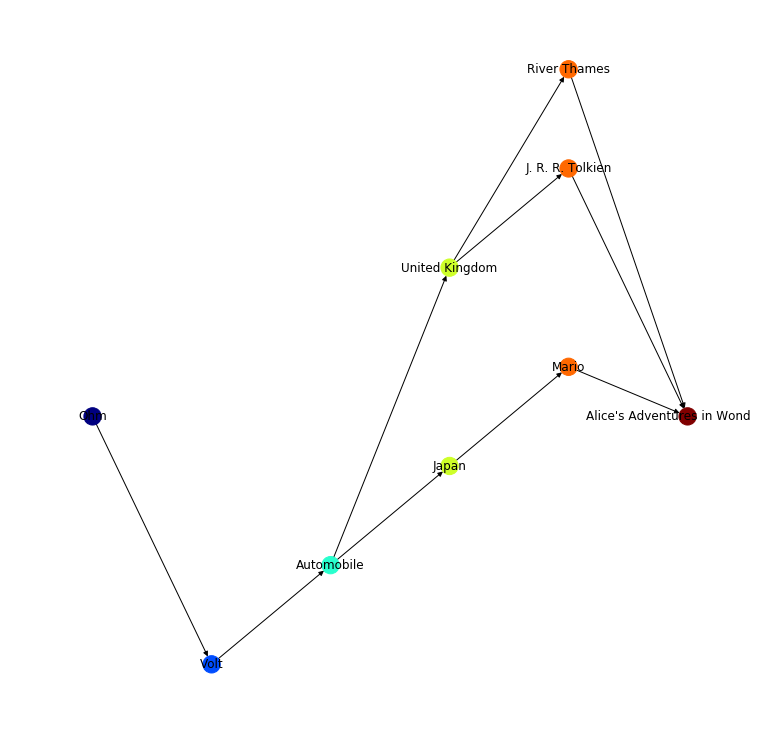

In [76]:
path_length = len(correct_paths[0])
nb_paths = len(correct_paths)

nodes = [start_node, end_node] #will contain all the nodes
edges = [] #will contain all the edges
steps = [0, path_length-1] #will contain the index in which each node is in its path


for path in correct_paths:
    for i in range(path_length):
        
        node = path[i]
        if node not in nodes:
            nodes.append(node) #add node to the nodes if not already there
            steps.append(i)    #record which place it had in the path
            
        if i != path_length-1:
            edges.append((path[i], path[i+1])) #add the node's neighbour and itself as an edge

node_names = [] #convert nodes and edges to their names instead of indices
edge_names = []
for node in nodes:
    node_names.append(dataframe.loc[node, 'title'])
for edge in edges:
    edge_names.append((dataframe.loc[edge[0], 'title'], dataframe.loc[edge[1], 'title']))

G = nx.DiGraph()
G.add_nodes_from(node_names) #add the nodes and edges to the graph
G.add_edges_from(edge_names)

pos = {} #calculate the position each node will have, depending on its "steps" value (i.e. its position in the path)
for i in range(len(node_names)):
    pos[node_names[i]] = np.array([steps[i]/(path_length-1), i/len(node_names)])
    
pos[node_names[0]] = np.array([0,0.5]) #give start node and end node specific positions
pos[node_names[1]] = np.array([1,0.5])

size = max(path_length, nb_paths,10) #make figure a square of size 10 minimum, or adapt it to path length or number of paths
f = plt.figure(figsize=(size,size)) 
nx.draw(G, pos, cmap=plt.get_cmap('jet'), node_color=steps, with_labels = True) #draw the graph with colors corresponding to the "steps" value
f.savefig("graph.png")
#img = Image.open('graph.png')
#img.show() 

In [77]:
#create the path for display
start_node = correct_paths[0][0]
end_node = correct_paths[0][-1]

nodes = [start_node, end_node]
edges = []

for path in correct_paths:
    for i in range(len(path)):
        node = path[i]
        if node not in nodes:
            nodes.append(node)
        if i != len(path)-1:
            edges.append((path[i], path[i+1]))

In [78]:
nodes_name_cat=[]
edges_name_cat=[]
for node in nodes:
    nodes_name_cat.append(find_cat(node))
for edge in edges:
    edges_name_cat.append((find_cat(edge[0]),find_cat(edge[1])))

/Users/jordanmetz/anaconda3/envs/Wiki_project/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


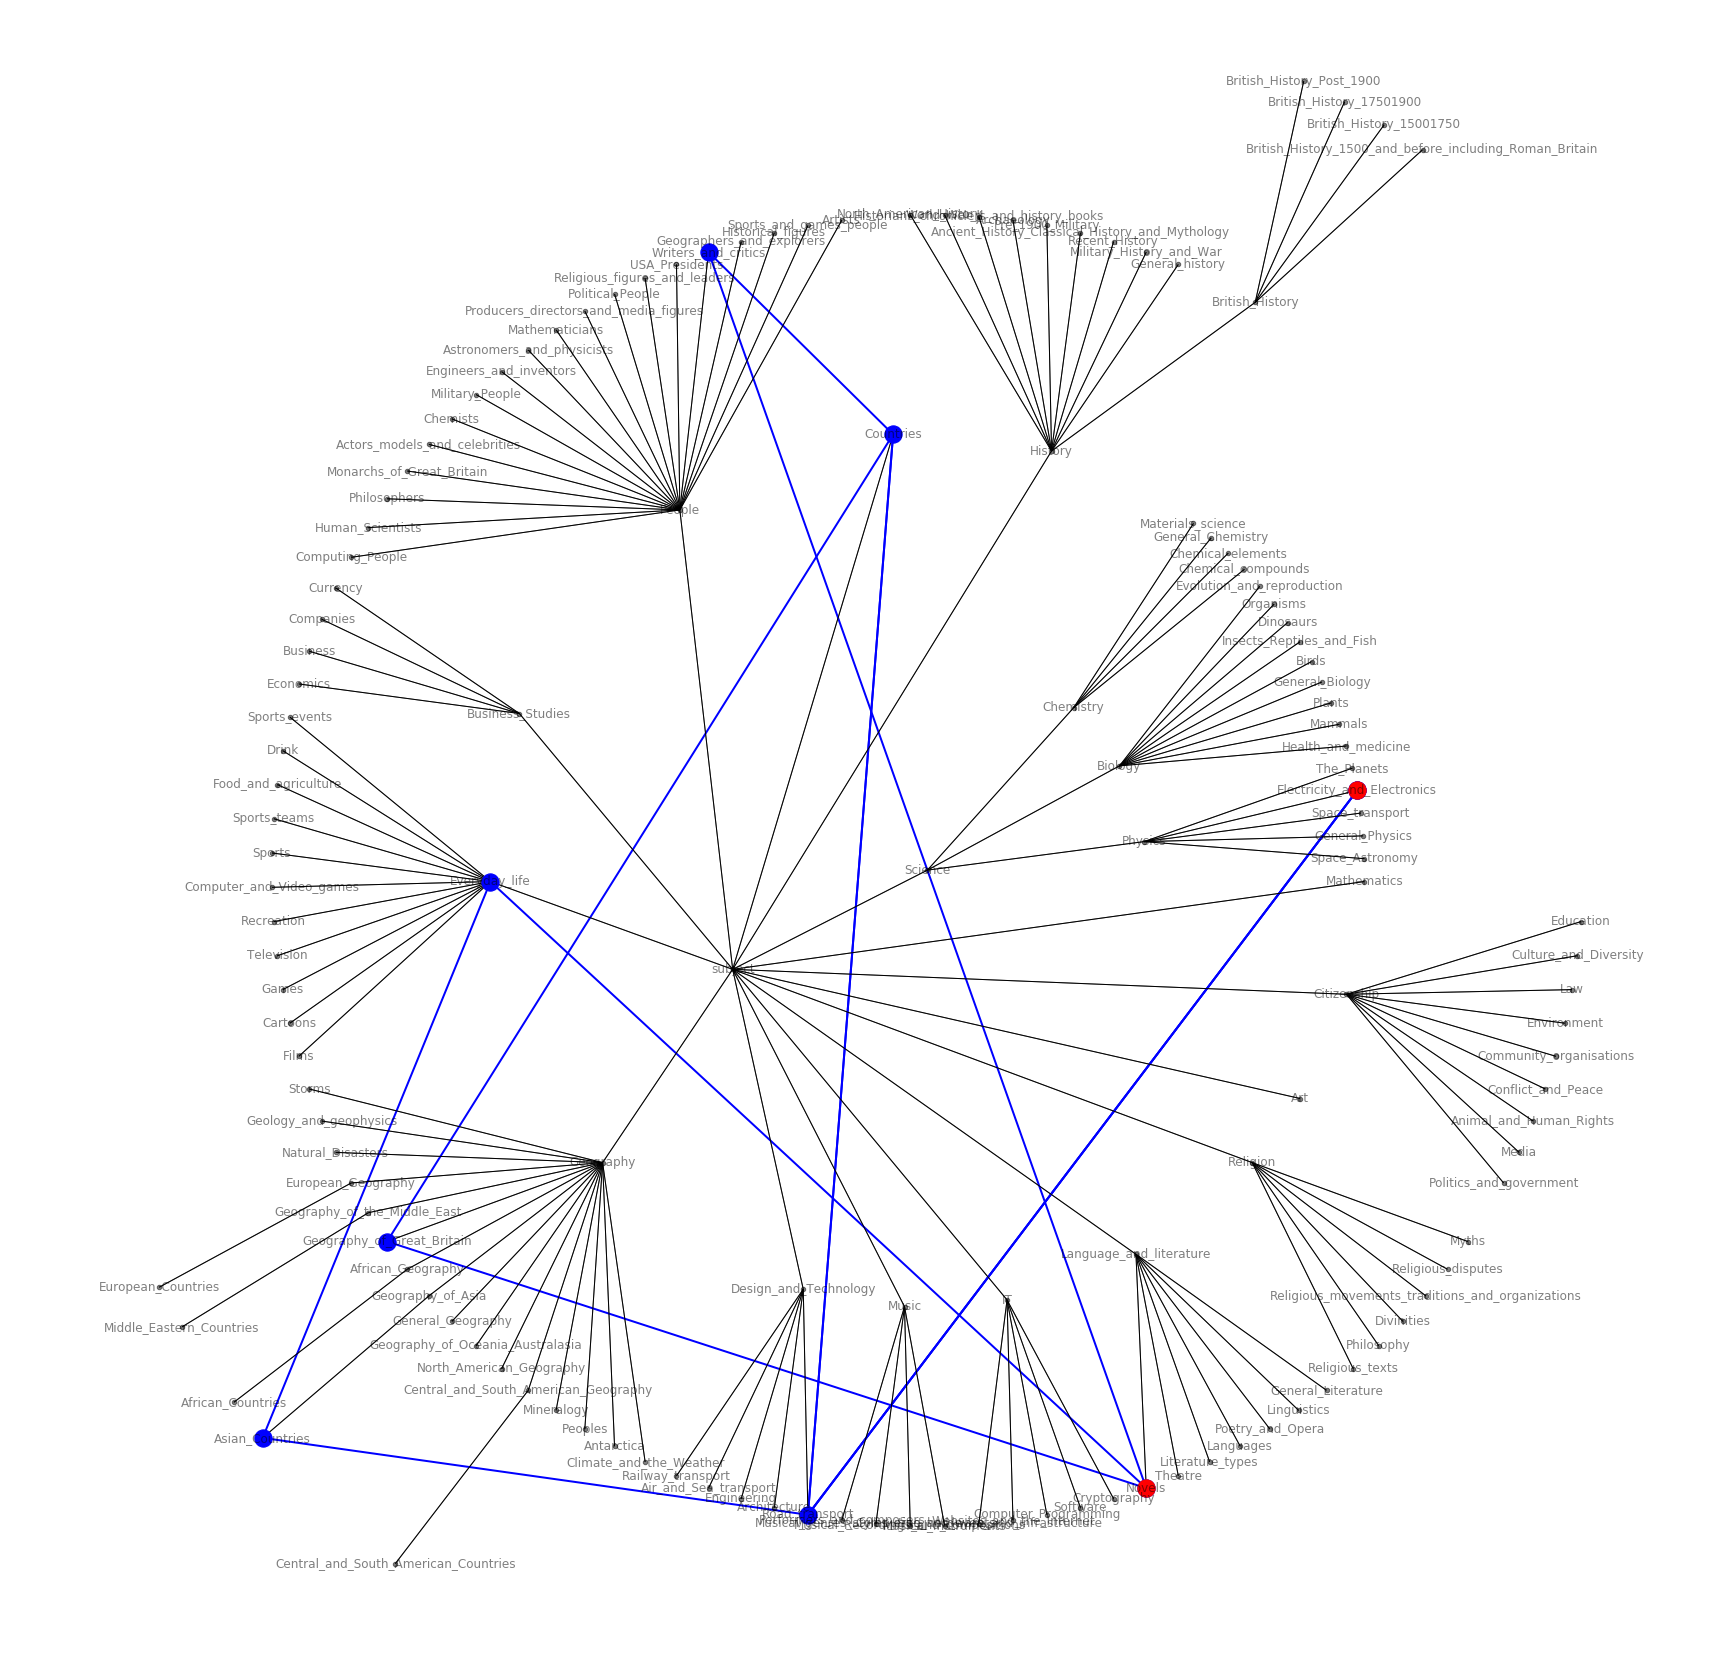

In [79]:
pos = graphviz_layout(G_cat, prog='twopi', args='')
fig = plt.figure(figsize=(30, 30))
plt.axis('equal')
nx.draw(G_cat, pos, node_size=20, alpha=0.5, node_color="black",edge_color='black', with_labels=True,arrows=True)
nx.draw(G_cat,pos,nodelist=nodes_name_cat,edgelist=edges_name_cat,edge_color="blue",width=2, alpha = 1, node_color="blue",cmap=plt.get_cmap('jet'),with_node=True)
nx.draw(G_cat,pos,nodelist=[find_cat(start_node),find_cat(end_node)], alpha = 1, node_color="red")
plt.savefig('wiki_circle.pdf')
plt.show()

/Users/jordanmetz/anaconda3/envs/Wiki_project/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


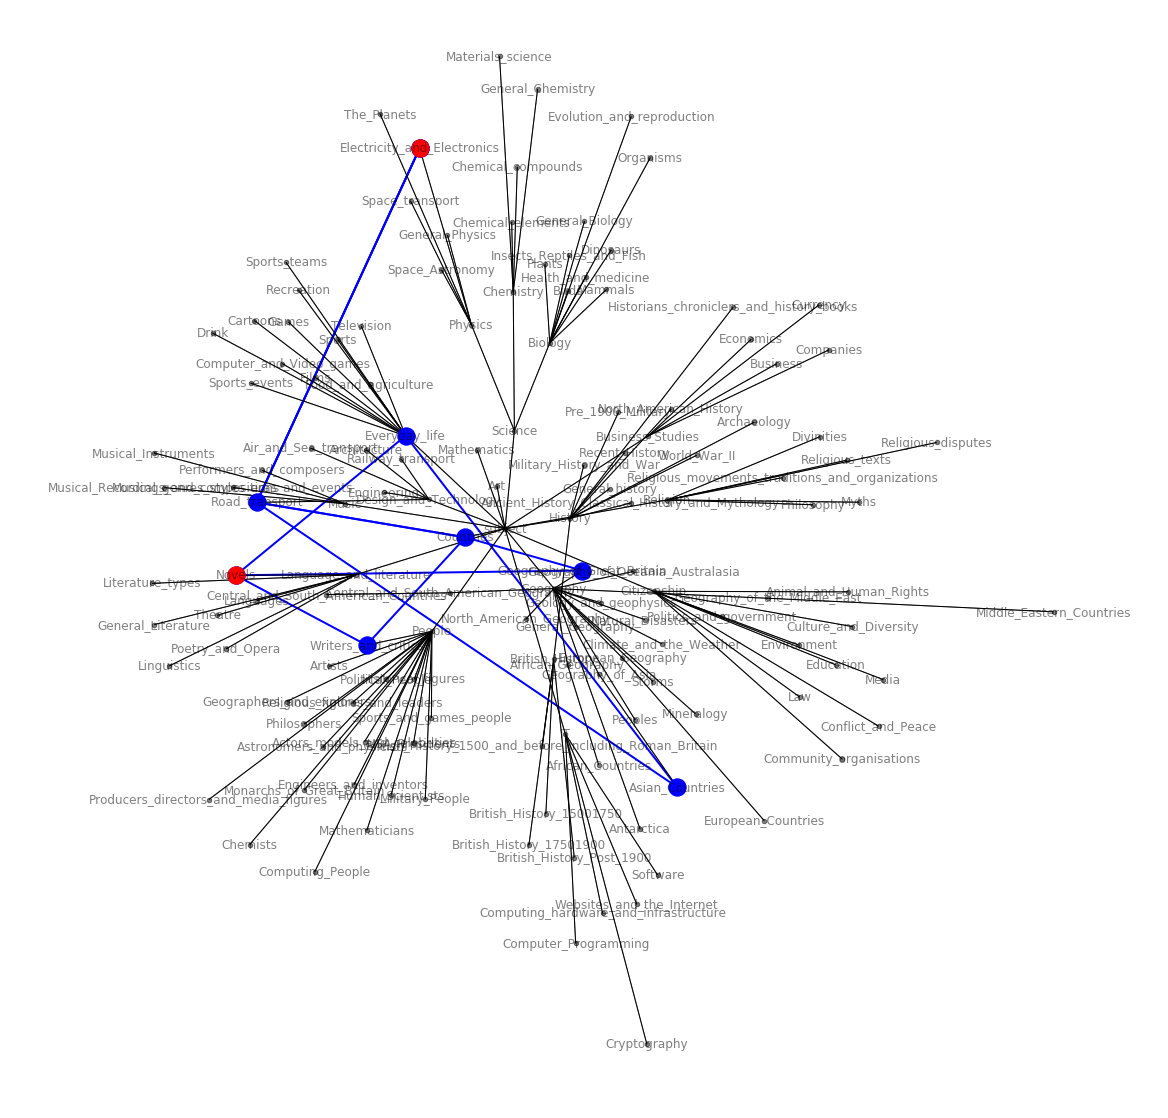

In [80]:
pos=nx.spring_layout(G_cat)
plt.figure(figsize=(20, 20))
plt.axis('equal')
nx.draw(G_cat, pos, node_size=20, alpha=0.5, node_color="black",edge_color='black', with_labels=True,arrows=True)
nx.draw(G_cat,pos,nodelist=nodes_name_cat,edgelist=edges_name_cat,edge_color="blue",width=2, alpha = 1, node_color="blue",cmap=plt.get_cmap('jet'))
nx.draw(G_cat,pos,nodelist=[find_cat(start_node),find_cat(end_node)], alpha = 1, node_color="red")
plt.savefig('wiki_spring.pdf')
plt.show()

In [81]:
G_cat.add_edges_from(edges_name_cat,weight=10000) #add the path's link to the graph for gephi

nx.write_gexf(G_cat, 'wikipedia_shortest_path.gexf')

Starting- and end- category

In [82]:
print(find_cat(start_node),find_cat(end_node))
print(find_main_cat(start_node), find_main_cat(end_node))

Electricity_and_Electronics Novels
Science Language_and_literature


## Checking path length lower than 7

In [83]:
# test
def short_algo(start_node, end_node):
    out_neighbours = [[start_node]] #out paths from the start node will go here
    in_neighbours = [[end_node]] #in paths to the end node will go here
    correct_paths = [] #paths from start node to end node will go here

    len_counter = 1 #limit to not try paths that are too long
    #in this loop we will successively propagate the out-paths and the in-paths until they reach each other
    while len_counter < 7:

        #generate out-paths and check if they have reached the in-paths
        out_neighbours = generate_out_paths(out_neighbours)
        correct_paths = correct_paths + check_paths(out_neighbours, in_neighbours)
        if correct_paths != []:
            break #if so, we don't want to check longer paths
        len_counter = len_counter + 1

        #generate in-paths and check if they have reached the out-paths
        in_neighbours = generate_in_paths(in_neighbours)
        correct_paths = correct_paths + check_paths(out_neighbours, in_neighbours)
        if correct_paths != []:
            break #if so, we don't want to check longer paths
        len_counter = len_counter + 1
        
    if len(correct_paths) == 0:
        return 0
    else:
        return len(correct_paths[0]) - 1

In [84]:
for i in range(1):
    start_node = int(rnd.random()*n_nodes)
    end_node = int(rnd.random()*n_nodes)
    start_node_name = dataframe.loc[start_node, 'title']
    end_node_name = dataframe.loc[end_node, 'title']
    
    length = short_algo(start_node, end_node)
    if length > 4:
        print("Length:", length, ":\t", start_node, start_node_name, "\t->\t", end_node, end_node_name)

# Application 2: Building category relationship graph

### Reloading data

In [85]:
dataframe = pd.read_csv('dataframe_final_none.tsv', sep='\t', encoding='utf-8', engine='python') #dataframe of main component
dataframe = make_df_readable(dataframe)
adjacency = np.load('adjacency_final.npy') #directed adjacency matrix of main component

#adjaceny[i,j] = 1 means link i->j exists (directed)

n_nodes = len(adjacency)

In [86]:
#extracting categories names
categories = []
for idx, rows in dataframe.iterrows():
    if dataframe.loc[idx,'Label1'] != "None":
        label = dataframe.loc[idx,'Label1'].split('.')[1]
        if label not in categories:
            categories.append(label)

In [87]:
#making more didactic dataframe
dataframe = pd.read_csv('dataframe_final_none.tsv', sep='\t', encoding='utf-8', engine='python') #dataframe of main component
dataframe = make_df_readable(dataframe)

cols = ['Label1','Label2','Label3']

for idx, rows in dataframe.iterrows():
    for col in cols:
        cat = dataframe.loc[idx,col]
        if cat != "None":
            dataframe.at[idx,col] = cat.split('.')[1]

### Designing functions

In [88]:
# this function takes a category name as input and returns the nodes that are in this category as output
def make_nodes(category):
    
    node_names = []
    nodes = []

    for idx, rows in dataframe.iterrows():
        for col in cols:
            if dataframe.loc[idx,col] == category and dataframe.loc[idx,'title']:
                node_names.append(dataframe.loc[idx,'title'])
                nodes.append(dataframe.index[idx])

    #at this point, we also have the article names in the category if needed (node_names)
    
    return nodes

In [89]:
# input:
# node: a node
# adjacency: the directed adjacency matrix of the graph
# categories: the list of categories of the graph
# output: a dictionnary containing the number of connections from node to each category
def get_neigh_cats(node,adjacency,categories):
    
    neighbours = []
    
    for i in range(len(adjacency)):
        if adjacency[node,i] == 1:
            neighbours.append(i) #find the node's neighbours
    
    neigh_cats = [] #will contain the categories of the node's neighbours
    
    for neigh in neighbours:
        neigh_cats.append(dataframe.loc[neigh,'Label1']) 
        neigh_cats.append(dataframe.loc[neigh,'Label2'])
        neigh_cats.append(dataframe.loc[neigh,'Label3'])

    cat_count = {}
    for cat in categories:
        cat_count[cat] = neigh_cats.count(cat) #build a dictionary to return
    
    return cat_count

In [90]:
#this function calculates the number of connections from category to all other categories, and returns them as a dictionary
def calculate_weights(categories, category, nodes):
    un_adj = np.load("undirected_adjacency_final.npy") #use undirected graph to count connections
    
    cat_count = {}
    for node in nodes: # for each node in the category
        node_count = get_neigh_cats(node,un_adj,categories) #find the number of connections to each neighbouring categories
        for cat in categories:
            cat_count[cat] = cat_count.get(cat,0) + node_count.get(cat) #add that number to the total
            
    return cat_count

In [91]:
def display_graph(G,node_sizes,total_weights):
    pos=nx.circular_layout(G) # positions for all nodes

    f = plt.figure(figsize=(20,20))
    # nodes
    nx.draw_networkx_nodes(G,pos,node_size=node_sizes)

    # edges
    nx.draw_networkx_edges(G,pos,width=total_weights,edge_color='g')

    # labels
    nx.draw_networkx_labels(G,pos,font_size=20)


    plt.axis('off')
    plt.savefig("graph.png")
    plt.show

### Main

/Users/jordanmetz/anaconda3/envs/Wiki_project/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


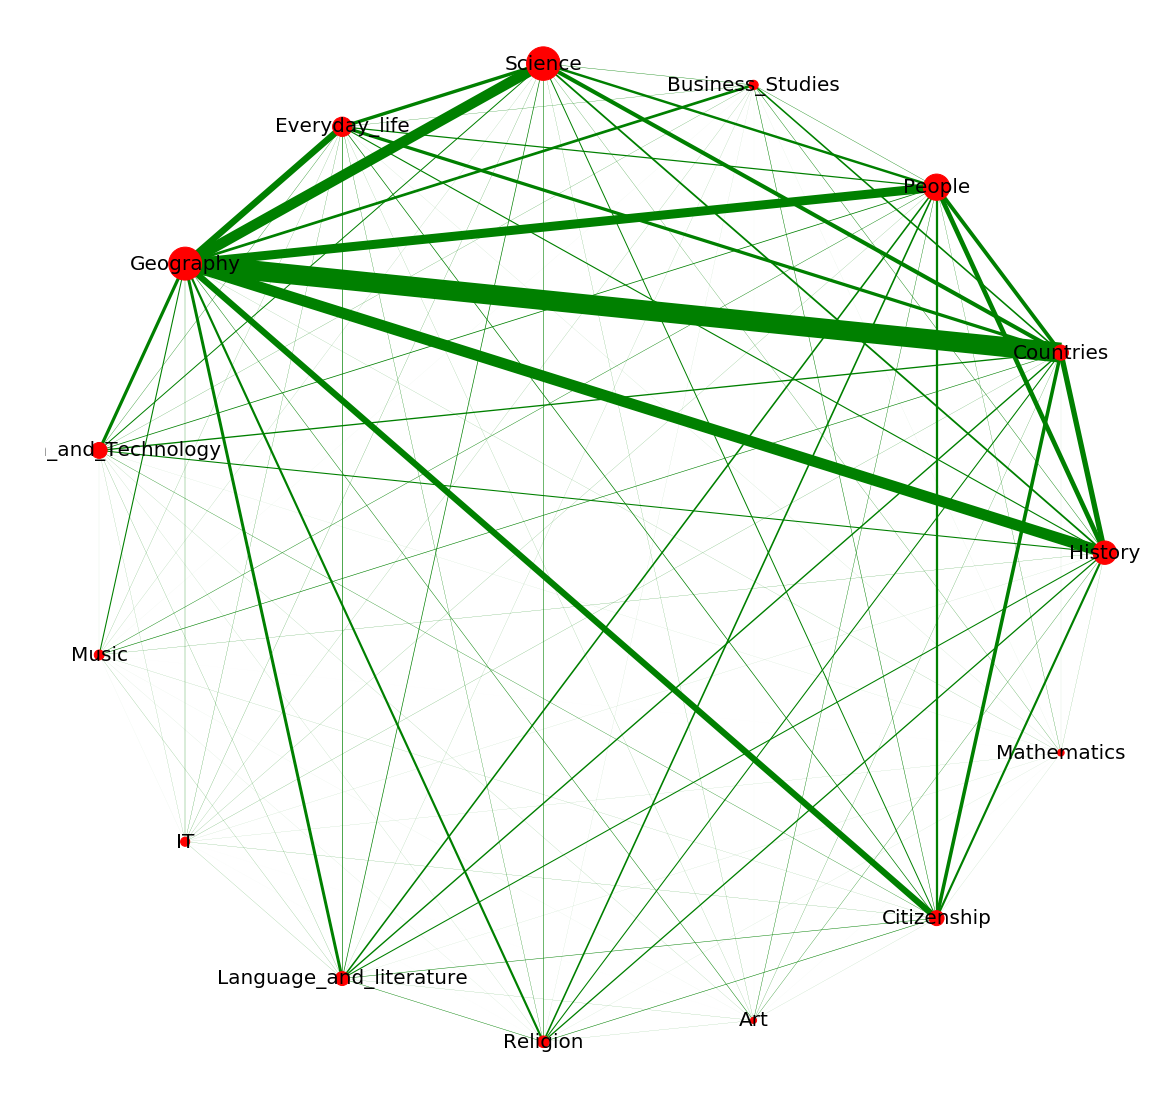

In [92]:
#constructing the category graph
G = nx.Graph()
G.add_nodes_from(categories)
total_weights = []
node_sizes = []

connectivity = {}

for i in range(len(categories)): #for each category
    cat = categories[i]
    
    nodes = make_nodes(cat) #define which nodes are contained in the category
    node_sizes.append(len(nodes))
    weights = calculate_weights(categories,cat,nodes) #calculate the number of connections from that category to other categories
    
    connectivity[cat] = weights
    
    for j in range(len(categories)):
        catcat = categories[j]
        if j > i:
            G.add_edge(cat,catcat,weight=weights.get(catcat)) #adding the weighted edges
            total_weights.append(weights.get(catcat))
            
total_weights = [20*i/max(total_weights) for i in total_weights]
    
display_graph(G,node_sizes,total_weights)

# Application 3: suggest gateway articles between two categories

### Designing functions

In [93]:
# cat1, cat2: the first and second categories
# categories: the list of categories
# connectivity: the dictionary containing the number of connections between each pair of categories
# remove_geography: if true, do not suggest geography articles
# remove_countries: if true, do not suggest countries articles
# output: the gateway category between cat1 and cat2
def tuple_finder(cat1, cat2, categories, connectivity, remove_geography=False, remove_countries=False):

    scores_cat1 = connectivity[cat1]
    scores_cat2 = connectivity[cat2]
    scores_cat1[cat1] = 0 #a category's own score is zero (you can't choose yourself)
    scores_cat2[cat2] = 0

    minimas = {}
    for cat in categories:
        # we will calculate a gateway score for all categories.
        # for a category vcat, its gateway score is the smallest number of connections between cat-cat1 and cat-cat2
        minimas[cat] = min(scores_cat1[cat], scores_cat2[cat])
    
    #then we choose the category that has the highest minimum connection to cat1 and cat2.
    #this category will maximize connections between cat1 and cat2
    sorted_minimas = dict(sorted(minimas.items(), key=operator.itemgetter(1), reverse=True))
    
    #eventually remove geography or countries
    if remove_geography:
        del sorted_minimas["Geography"]
    if remove_countries:
        del sorted_minimas["Countries"]
        

    return next(iter(sorted_minimas))

In [94]:
# this function pergroms the path finding of application 1, but with a path length threshold, and only returns the path length
def find_distance(start_node, end_node, threshold=7):
    out_neighbours = [[start_node]] #out paths from the start node will go here
    in_neighbours = [[end_node]] #in paths to the end node will go here
    correct_paths = [] #paths from start node to end node will go here

    len_counter = 1 #limit to not try paths that are too long
    #in this loop we will successively propagate the out-paths and the in-paths until they reach each other
    while len_counter < threshold:

        #generate out-paths and check if they have reached the in-paths
        out_neighbours = generate_out_paths(out_neighbours)
        correct_paths = correct_paths + check_paths(out_neighbours, in_neighbours)
        if correct_paths != []:
            break #if so, we don't want to check longer paths
        len_counter = len_counter + 1

        #generate in-paths and check if they have reached the out-paths
        in_neighbours = generate_in_paths(in_neighbours)
        correct_paths = correct_paths + check_paths(out_neighbours, in_neighbours)
        if correct_paths != []:
            break #if so, we don't want to check longer paths
        len_counter = len_counter + 1
        
    if len(correct_paths) == 0:
        return 0
    else:
        return len(correct_paths[0]) - 1

In [95]:
#this function performs the path finding of application 1.
def find_paths(start_node, end_node):
    out_neighbours = [[start_node]] #out paths from the start node will go here
    in_neighbours = [[end_node]] #in paths to the end node will go here
    correct_paths = [] #paths from start node to end node will go here

    len_counter = 1 #limit to not try paths that are too long
    #in this loop we will successively propagate the out-paths and the in-paths until they reach each other
    while len_counter < 7:

        #generate out-paths and check if they have reached the in-paths
        out_neighbours = generate_out_paths(out_neighbours)
        correct_paths = correct_paths + check_paths(out_neighbours, in_neighbours)
        if correct_paths != []:
            break #if so, we don't want to check longer paths
        len_counter = len_counter + 1

        #generate in-paths and check if they have reached the out-paths
        in_neighbours = generate_in_paths(in_neighbours)
        correct_paths = correct_paths + check_paths(out_neighbours, in_neighbours)
        if correct_paths != []:
            break #if so, we don't want to check longer paths
        len_counter = len_counter + 1
    
    return correct_paths

### Main

In [96]:
cat1 = input("First Category: ")
cat2 = input("Second Category: ")

#find the gateway category between cat1 and cat2
best = tuple_finder(cat1,cat2,categories,connectivity, remove_geography=True, remove_countries=True)
print("")
print("You should talk about", best)

#get the nodes of all three categories
cat1_nodes = make_nodes(cat1)
cat2_nodes = make_nodes(cat2)
best_nodes = make_nodes(best)

suggestions = []
queue = []

#check paths from cat1 to cat2
while len(queue) < 20:
    node1 = rnd.choice(cat1_nodes)
    node2 = rnd.choice(cat2_nodes)
    length = find_distance(node1, node2, threshold=3) #find paths from cat1 to cat2
    if length == 2: #keep only paths of length 2
        correct_paths = find_paths(node1,node2)
        for path in correct_paths:
            if path[1] in best_nodes: #keep only paths that go through best category
                queue.append(path[1]) #add the intermediary node to the queue to check
                
#check paths from cat2 to cat1
while len(suggestions) < 10:
    node1 = rnd.choice(cat1_nodes)
    node2 = rnd.choice(cat2_nodes)
    length = find_distance(node1, node2, threshold=3) #find paths from cat2 to cat1
    if length == 2: #keep only paths of length 2
        correct_paths = find_paths(node1,node2)
        for path in correct_paths:
            if path[1] in queue: #keep only paths that go through best category and are known to be intermediaries
                suggestions.append(path[1])
                
#removing duplicates
suggestions = list(set(suggestions))

#find articles url

#print out the suggestions
print("")
print("Here are some more specific subjects you could talk about:")
dataframe_raw = pd.read_csv('dataframe_final.tsv', sep='\t', encoding='utf-8', engine='python')
for suggestion in suggestions:
    #find article url
    name = dataframe_raw.loc[suggestion, 'title']
    url = "en.wikipedia.org/wiki/" + name
    print(suggestion, "\t", dataframe.loc[suggestion, 'title'], "\t", url)
    

First Category: Science
Second Category: Language_and_literature

You should talk about People

Here are some more specific subjects you could talk about:
1990 	 Homer 	 en.wikipedia.org/wiki/Homer
167 	 Albert Einstein 	 en.wikipedia.org/wiki/Albert_Einstein
4490 	 William Shakespeare 	 en.wikipedia.org/wiki/William_Shakespeare
1934 	 Hippocrates 	 en.wikipedia.org/wiki/Hippocrates
336 	 Aristotle 	 en.wikipedia.org/wiki/Aristotle
3167 	 Paul Dirac 	 en.wikipedia.org/wiki/Paul_Dirac
